In [ ]:
# might need to install things
#!pip install pydicom
#!pip install opencv-python

Random Forest Classifier

In [ ]:
import os, sys
from sklearn import svm, datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
import pickle

In [ ]:
# wherever the directory for the TCGA-BRCA file is
directory = "TCGA-BRCA/"

In [ ]:
# metadata patient name has period instead of -
def convert_patient_name(df):
    new = [x.replace(".", "-") for x in df.columns]
    df.columns = new
    return df

#import metadata + gene expression data
rna_express = convert_patient_name(pd.read_csv("Human__TCGA_BRCA__UNC__RNAseq__HiSeq_RNA__01_28_2016__BI__Gene__Firehose_RSEM_log2.cct", sep = "\t"))
mutant = convert_patient_name(pd.read_csv("Human__TCGA_BRCA__WUSM__Mutation__GAIIx__01_28_2016__BI__Gene__Firehose_MutSig2CV.cbt", sep = "\t"))
methyl = convert_patient_name(pd.read_csv("Human__TCGA_BRCA__JHU_USC__Methylation__Meth450__01_28_2016__BI__Gene__Firehose_Methylation_Prepocessor.cct", sep = "\t"))
miRNA = convert_patient_name(pd.read_csv("Human__TCGA_BRCA__BDGSC__miRNASeq__HS_miR__01_28_2016__BI__Gene__Firehose_RPKM_log2.cct", sep="\t"))
clinical = convert_patient_name(pd.read_excel('brca-clinicalforwiki.xls'))

express_feature = rna_express['attrib_name'].to_numpy()
mutant_feature = mutant['attrib_name'].to_numpy()
methyl_feature = methyl['attrib_name'].to_numpy()
miRNA_feature = miRNA['attrib_name'].to_numpy()
features = np.concatenate([express_feature, mutant_feature, methyl_feature, miRNA_feature])

check_express = rna_express.columns.to_list()[1:]
check_mut = mutant.columns.to_list()[1:]
check_methyl = methyl.columns.to_list()[1:]
check_miRNA = miRNA.columns.to_list()[1:]

# function for getting the intersection of all patients w/ gene expression and imaging data
def intersection(list_of_list):
    union = list_of_list[0]
    for l in list_of_list:
        union = list(set(union) & set(l))
    return union

#actually found out that metadata lied and not all gene expression patients indicated have dicom images, load manually
patient = ['TCGA-BH-A28Q', 'TCGA-AR-A24X', 'TCGA-E2-A1IK', 'TCGA-E2-A1IE', 'TCGA-AR-A1AQ', 'TCGA-AR-A1AX', 'TCGA-BH-A0E2', 'TCGA-E2-A1LG', 'TCGA-E2-A1L9', 'TCGA-E2-A1L7', 'TCGA-E2-A1IJ', 'TCGA-BH-A0H3', 'TCGA-BH-A0B5', 'TCGA-E2-A1B1', 'TCGA-BH-A0DG', 'TCGA-E2-A1B6', 'TCGA-BH-A0DI', 'TCGA-E2-A15K', 'TCGA-BH-A201', 'TCGA-E2-A15J', 'TCGA-E2-A1IG', 'TCGA-AR-A1AN', 'TCGA-E2-A1II', 'TCGA-E2-A1IN', 'TCGA-AR-A24S', 'TCGA-BH-A0AZ', 'TCGA-BH-A0DV', 'TCGA-E2-A1B5', 'TCGA-BH-A0B6', 'TCGA-BH-A0HA', 'TCGA-BH-A0BT', 'TCGA-BH-A202', 'TCGA-E2-A15I']

#find all gene expression subsection w/ patients w/ dicom images
union_list = intersection([check_express, check_methyl, check_mut, check_miRNA, patient])
u_express = rna_express[union_list]
u_mut = mutant[union_list]
u_methyl = methyl[union_list]
u_miRNA = miRNA[union_list]

stage_mapping = {
    'Stage I': 0,
    'Stage IA': 0,
    'Stage IB': 0,
    'Stage II': 1,
    'Stage IIA': 1,
    'Stage IIB': 1,
    'Stage III': 2,
    'Stage IIIA': 2,
    'Stage IIIB': 2,
    'Stage IIIC': 2
}

#concatenate into pandas dataframe
mort_df = clinical[clinical['bcr_patient_barcode'].isin(union_list)].T
mort_df.reset_index(drop=True, inplace=True)
mort_df.columns = mort_df.iloc[0]
mort_df = mort_df[1:].iloc[[3]]
mort_df.replace(stage_mapping, inplace=True)
#matrix of concatenated gene expression, last row is stage of cancer
u_all_gene_exp = pd.concat([u_express, u_mut, u_methyl, u_miRNA, mort_df], ignore_index=True)
#test_array = np.nan_to_num(u_all_gene_exp.iloc[:-1].T.to_numpy(), nan = 0)
mort_array = u_all_gene_exp.iloc[-1].to_numpy()

#train and model the RF
#data, concatenated matrix of all genes
gene_exp = u_all_gene_exp.iloc[:-1]
X = np.nan_to_num(gene_exp.T.to_numpy(), nan = 0)
y = mort_array

#initialize a random forest classifier
random_forest_class = RandomForestClassifier(min_samples_leaf=3)

#start a leave one out object
leave_one = LeaveOneOut()

#make an accurate list and prediction list
accuracy = []
rf_predict = []

#loop through the leave one out and train the random forest
for train, test in leave_one.split(X):
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]

    random_forest_class.fit(X_train, y_train)

    #predict
    predicted = random_forest_class.predict(X_test)
    rf_predict.append(predicted[0])

    #accuracy
    acc = accuracy_score(y_test, predicted)
    accuracy.append(acc)
mean_acc = np.mean(accuracy)
print("Mean Accuracy:", mean_acc)

Mean Accuracy: 0.45454545454545453


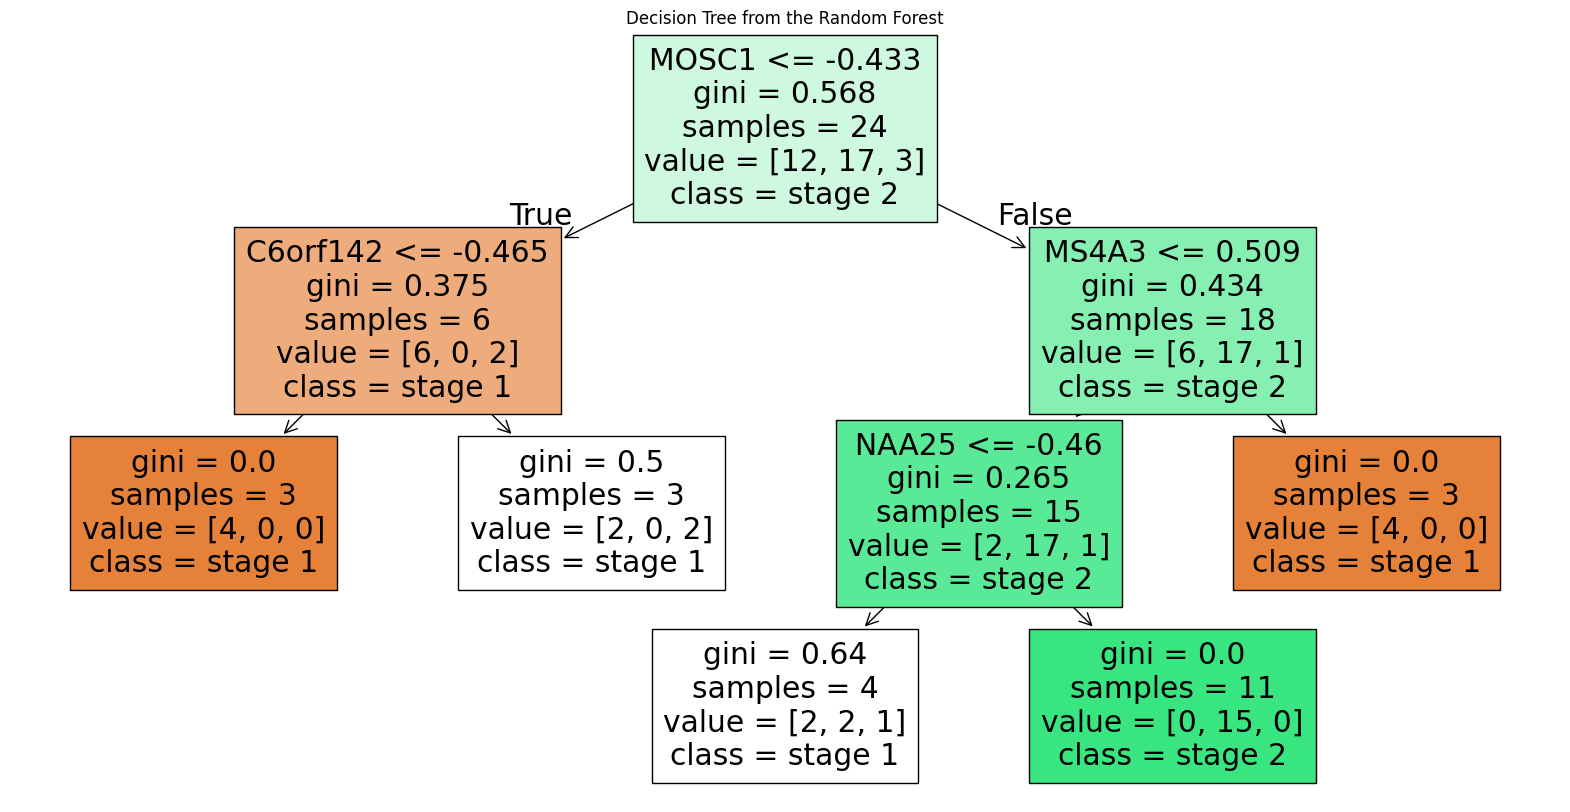

In [ ]:
# Plot the tree using the plot_tree function from sklearn
first_tree = random_forest_class.estimators_[0]
plt.figure(figsize=(20,10))  # Set figure size to make the tree more readable
stages = np.array(["stage 1", "stage 2", "stage 3"])
plot_tree(first_tree, feature_names=features, class_names=stages, filled=True)
plt.title("Decision Tree from the Random Forest")
plt.show()

In [ ]:
patient_list = u_all_gene_exp.columns.tolist()

CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import pydicom
import cv2
import os
from concurrent.futures import ThreadPoolExecutor
import pandas as pd

# Define the input shape for the CNN (standard for most models working with RGB images)
input_shape = (224, 224, 3)

# Build a custom CNN model
model = Sequential([
    # First convolutional layer with 32 filters and ReLU activation
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D((2, 2)),  # Max pooling to reduce spatial dimensions

    # Second convolutional layer with 64 filters
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Third convolutional layer with 128 filters
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flatten layer to transform 3D feature maps to 1D feature vector
    Flatten(),

    # Fully connected layer with 256 neurons and dropout for regularization
    Dense(256, activation='relu'),
    Dropout(0.5),

    # Second fully connected layer with 128 neurons and dropout
    Dense(128, activation='relu'),
    Dropout(0.3),

    # Output layer with softmax activation for three-class classification (stage 1, 2, 3)
    Dense(3, activation='softmax')
])

# Compile the model with Adam optimizer and categorical crossentropy loss
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary for a detailed view of layers and parameters
model.summary()

# Load the CSV file containing patient data
csv_path = directory + "ml_project_patient_data.csv"
patient_data = pd.read_csv(csv_path)

# Filter and map the ajcc_neoplasm_disease_stage to numeric labels
stage_mapping = {
    'Stage I': 0,
    'Stage IA': 0,
    'Stage IB': 0,
    'Stage II': 1,
    'Stage IIA': 1,
    'Stage IIB': 1,
    'Stage III': 2,
    'Stage IIIA': 2,
    'Stage IIIB': 2,
    'Stage IIIC': 2
}

# Exclude Stage IV
patient_data = patient_data[patient_data['ajcc_neoplasm_disease_stage'].isin(stage_mapping.keys())]
patient_data['stage_label'] = patient_data['ajcc_neoplasm_disease_stage'].map(stage_mapping)

# Create a mapping of patient IDs to stage labels
stage_label_mapping = {
    row['bcr_patient_barcode']: row['stage_label']
    for _, row in patient_data.iterrows()
}

# Function to load and preprocess a single DICOM image
def preprocess_dicom(filepath):
    dicom = pydicom.dcmread(filepath)  # Read DICOM file
    image = dicom.pixel_array  # Extract image data

    # Handle different data types by scaling to 8-bit if necessary
    if image.dtype != np.uint8:
        image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Check if the image is grayscale (single channel) or already multi-channel
    if len(image.shape) == 2 or image.shape[-1] == 1:  # Grayscale image
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)  # Convert to RGB

    # Resize to 224x224 and normalize pixel values
    image = cv2.resize(image, (224, 224))
    image = image / 255.0  # Normalize pixel values to range [0, 1]

    return image

# Function to load and preprocess DICOM images from a structured directory using multithreading
def load_dicom_images(directory):
    images = []  # List to hold image data
    labels = []  # List to hold corresponding labels
    file_label_pairs = []  # Collect all file paths and their labels
    patient_ids_list = [] # save the patient ids

    # Traverse the directory structure
    for patient_folder in os.listdir(directory):
        patient_path = os.path.join(directory, patient_folder)
        if os.path.isdir(patient_path):
            for date_folder in os.listdir(patient_path):
                date_path = os.path.join(patient_path, date_folder)
                if os.path.isdir(date_path):
                    for location_folder in os.listdir(date_path):
                        location_path = os.path.join(date_path, location_folder)
                        if os.path.isdir(location_path):
                            for file in os.listdir(location_path):
                                filepath = os.path.join(location_path, file)
                                if filepath.endswith('.dcm'):  # Check for DICOM file extension
                                    # Assign label based on stage label mapping
                                    patient_id = patient_folder.replace('.', '-')
                                    label = stage_label_mapping.get(patient_id, None)
                                    if label is not None:
                                        file_label_pairs.append((filepath, label))
                                        patient_ids_list.append(patient_id)

    # Use multithreading to process images faster
    def process_pair(pair):
        filepath, label = pair
        image = preprocess_dicom(filepath)
        return image, label

    with ThreadPoolExecutor() as executor:
        results = executor.map(process_pair, file_label_pairs)

    for image, label in results:
        images.append(image)
        labels.append(label)

    return np.array(images), np.array(labels), np.array(patient_ids_list)

# Load DICOM images and their labels from the specified directory
data_directory = directory

image_data, labels, patient_ids_list = load_dicom_images(data_directory)

# Ensure there is data to split
if len(image_data) == 0 or len(labels) == 0:
    raise ValueError("No data loaded. Please check the DICOM files or directory structure.")

# Convert labels to categorical format (one-hot encoding for three-class classification)
labels = tf.keras.utils.to_categorical(labels, num_classes=3)

# Split the dataset into 50% training and 50% testing
X_train, X_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.5, random_state=42)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,277,955 (84.98 MB)

 Trainable params: 22,277,955 (84.98 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model on the training set
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),  # Use the test set for validation during training
    epochs=10,  # Number of training epochs
    batch_size=32  # Number of samples per training batch
)

# Evaluate the model on the test set
val_loss, val_accuracy = model.evaluate(X_test, y_test)
print(f"Validation Accuracy: {val_accuracy:.2f}")
print(f"Validation Loss: {val_loss:.2f}")

# Get predictions on the test set
predictions = model.predict(X_test)

# Convert predictions and true labels from one-hot encoding to class indices
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Print classification report and overall accuracy
print("Classification Report:\n", classification_report(true_classes, predicted_classes))
print("Overall Accuracy:", accuracy_score(true_classes, predicted_classes))

Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 106s 3s/step - accuracy: 0.4466 - loss: 1.1531 - val_accuracy: 0.5022 - val_loss: 0.9670
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 121s 3s/step - accuracy: 0.5137 - loss: 0.9719 - val_accuracy: 0.5639 - val_loss: 0.8987
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.5897 - loss: 0.8818 - val_accuracy: 0.6126 - val_loss: 0.7939
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.6732 - loss: 0.6745 - val_accuracy: 0.7716 - val_loss: 0.6403
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 114s 4s/step - accuracy: 0.7892 - loss: 0.5085 - val_accuracy: 0.8074 - val_loss: 0.5476
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.8738 - loss: 0.3135 - val_accuracy: 0.8366 - val_loss: 0.4960
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.9359 - loss: 0.1980 - val_accuracy: 0.8571 - val_loss: 0.5134
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 114s 4s/step - accuracy: 0.9461 - loss: 0.1475 - val_accuracy: 0.8398 - val_l

In [ ]:
# Get predictions on the test set
final_predictions = model.predict(image_data)

# Convert predictions and true labels from one-hot encoding to class indices
final_predicted_classes = np.argmax(final_predictions, axis=1)
final_true_classes = np.argmax(labels, axis=1)

58/58 ━━━━━━━━━━━━━━━━━━━━ 48s 812ms/step


In [ ]:
# Print classification report and overall accuracy
print("Classification Report:\n", classification_report(final_true_classes, final_predicted_classes))
print("Overall Accuracy:", accuracy_score(final_true_classes, final_predicted_classes))

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.90      0.92       638
           1       0.92      0.97      0.94       924
           2       0.93      0.88      0.91       285

    accuracy                           0.93      1847
   macro avg       0.93      0.92      0.92      1847
weighted avg       0.93      0.93      0.93      1847

Overall Accuracy: 0.9301570113697889


In [ ]:
#rearrange the prediction to match the patient - classify by most common image classifier
patient_dic = {}
for i in range(len(patient_ids_list)):
    if patient_ids_list[i] not in patient_dic:
        patient_dic[patient_ids_list[i]] = [final_predicted_classes[i]]
    else:
        patient_dic[patient_ids_list[i]].append(final_predicted_classes[i])

counter_prediction = []
for p in patient_list:
    final = np.argmax(np.bincount(np.array(patient_dic[p])))
    counter_prediction.append(final)

cnn_counter = np.array(counter_prediction)

print("Accuracy:", accuracy_score(mort_array, cnn_counter))
print("Classification Report:\n", classification_report(mort_array, cnn_counter))

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        10
         1.0       1.00      1.00      1.00        18
         2.0       1.00      1.00      1.00         5

    accuracy                           1.00        33
   macro avg       1.00      1.00      1.00        33
weighted avg       1.00      1.00      1.00        33



Adaboost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from scikeras.wrappers import KerasClassifier
import joblib

#predict is random forest output, CNN is image output (second term)
X = np.vstack((rf_predict, cnn_counter)).T
y = mort_array

#split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50)

#generate adaboost classifier
clf = AdaBoostClassifier(n_estimators=50, random_state=50)

#fit model
clf.fit(X_train, y_train)

#print out prediction accuracy
predictions = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, predictions))
print("Classification Report:\n", classification_report(y_test, predictions))

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         3
         1.0       1.00      1.00      1.00         5
         2.0       1.00      1.00      1.00         2

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



/Users/angelaxu/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


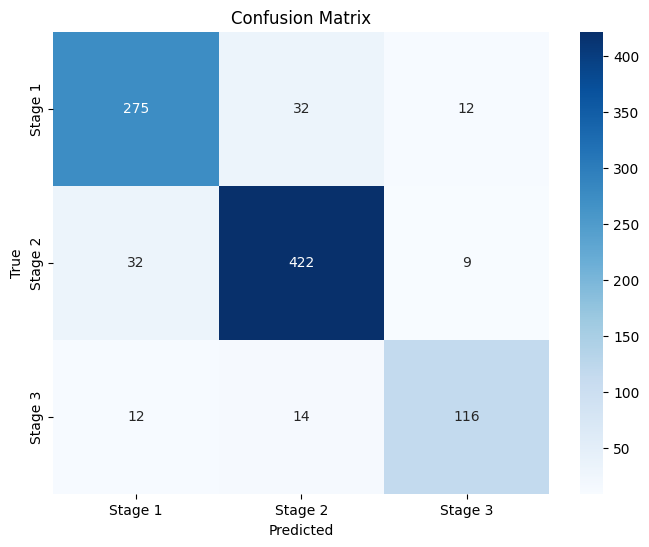

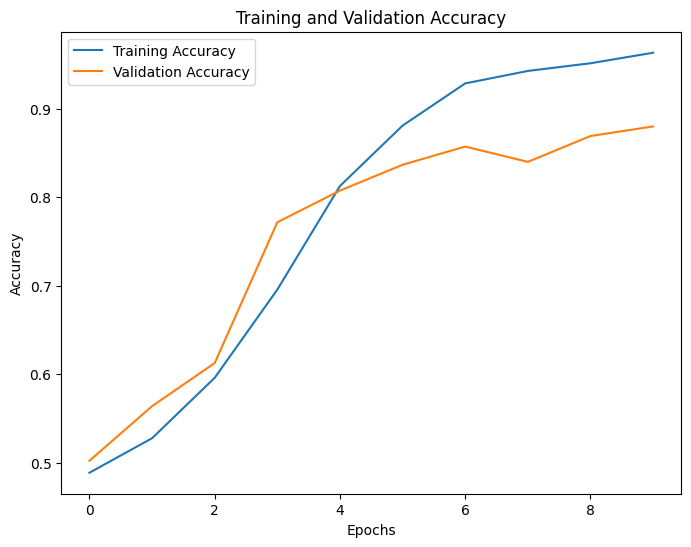

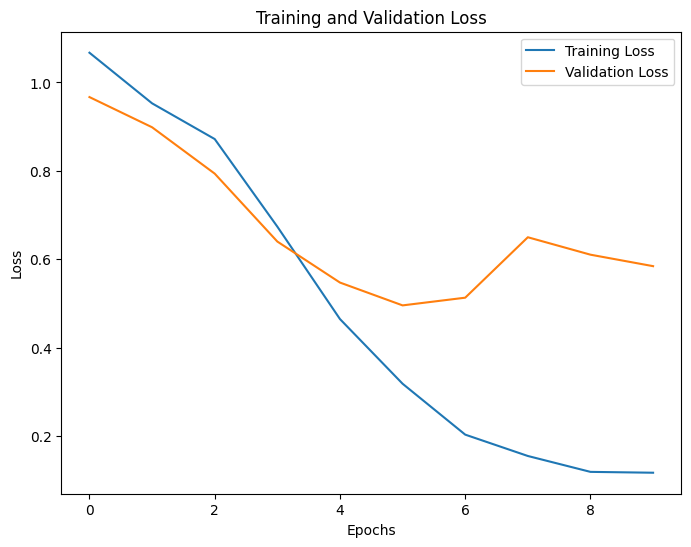

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Visualizations and Metrics

# Confusion Matrix
def plot_confusion_matrix(true_classes, predicted_classes):
    conf_matrix = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Stage 1', 'Stage 2', 'Stage 3'],
                yticklabels=['Stage 1', 'Stage 2', 'Stage 3'])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Training and Validation Accuracy Plot
def plot_accuracy(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label="Training Accuracy")
    plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

# Training and Validation Loss Plot
def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label="Training Loss")
    plt.plot(history.history['val_loss'], label="Validation Loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# Example Usage
# Assuming `history` is the model training history,
# `true_classes` are true labels, and `predicted_classes` are predictions

plot_confusion_matrix(true_classes, predicted_classes)
plot_accuracy(history)
plot_loss(history)

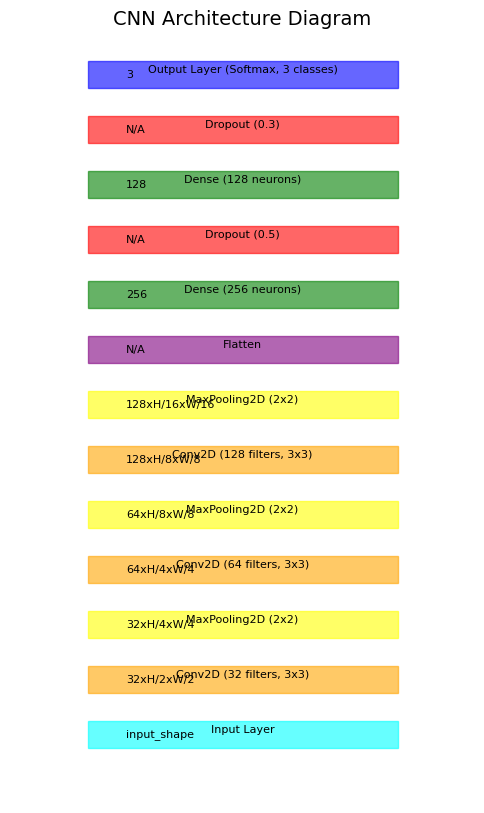

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def draw_cnn_diagram():
    fig, ax = plt.subplots(figsize=(6, 10))

    layers = [
        ("Input Layer", "input_shape", 1, "cyan"),
        ("Conv2D (32 filters, 3x3)", "32xH/2xW/2", 2, "orange"),
        ("MaxPooling2D (2x2)", "32xH/4xW/4", 3, "yellow"),
        ("Conv2D (64 filters, 3x3)", "64xH/4xW/4", 4, "orange"),
        ("MaxPooling2D (2x2)", "64xH/8xW/8", 5, "yellow"),
        ("Conv2D (128 filters, 3x3)", "128xH/8xW/8", 6, "orange"),
        ("MaxPooling2D (2x2)", "128xH/16xW/16", 7, "yellow"),
        ("Flatten", "N/A", 8, "purple"),
        ("Dense (256 neurons)", "256", 9, "green"),
        ("Dropout (0.5)", "N/A", 10, "red"),
        ("Dense (128 neurons)", "128", 11, "green"),
        ("Dropout (0.3)", "N/A", 12, "red"),
        ("Output Layer (Softmax, 3 classes)", "3", 13, "blue"),
    ]

    # Draw each layer
    for i, (name, shape, pos, color) in enumerate(layers):
        ax.add_patch(Rectangle((0.5, pos), 2, 0.5, color=color, alpha=0.6))
        ax.text(1.5, pos + 0.25, name, ha='center', va='bottom', fontsize=8)
        ax.text(0.75, pos + 0.25, shape, ha='left', va='center', fontsize=8)

    # Set axis limits and labels
    ax.set_ylim(0, len(layers) + 1)
    ax.set_xlim(0, 3)
    ax.axis('off')
    plt.title("CNN Architecture Diagram", fontsize=14)
    plt.show()

# Call the function to draw the diagram
draw_cnn_diagram()